![banner](https://learn.responsibly.ai/assets/banner.jpg)

# Class 4 - Discrimination & Fairness: Pre-Class Task

https://learn.responsibly.ai


In the fourth class, we will continue our journy into the challenge of fairness in machine learning.

The goal of this pre-class task is to get familiar with an healthcare dataset we will work on in the fourth class. It is an Electronic Health Record (EHR) dataset which contains an electronic version of patients' medical history. The dataset based on data from a US health insurance firm, so it conains also cost information. From privacy resons, the data went through an "anonomization" process, but we'll get into that in the next classes.

The following six tasks will help you to get familiar with this dataset, understand its various columns and their relation to each other.

Please go through the whole notebook before you start coding. You could plan your work better if you have first an overview of the task.

If you have any questions, please post them in the `#ds` channel in Discord or join the office hours.

Let's start!

## How to write your answers?


For each task, you should write a code and `print()` the answers to the questions. You should print them in the following format (see Task 1 example):

```python
print(f'T{task_number}-Q{question_number}: {answer}')
```

In some questions, you will need to display a data frame. The format of answering these type of question is:

```python
print(f'T{task_number}-Q{question_number}:')
display(answer_df)
```

We assume you are familiar with `pandas` package. If you are not, you can read this [toturial](https://realpython.com/pandas-python-explore-dataset/) (note that it contains much more than you need in this task, yet it can be handy as a reference when you answer the questions).

## Setup

In [52]:
!wget -q https://stash.responsibly.ai/4-fairness/activity/patients_data.csv -O patients_data.csv

%pip install -qqq git+https://github.com/ResponsiblyAI/railib.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from railib.fairness.second import plot_x_vs_y

sns.set()

## Dataset

### Meaning of column suffixes (endings)
* _t: indicates this is a time dependent variable from year t (e.g. t = 2020)
* _tm1: indicates this is a time dependent variable from year t minus 1 (t-1) (e.g. if t = 2021 then t - 1 = 2020).

### Variables categories

#### Can be used as target variables (because they are "at time t" ):

* Outcomes at time t: "outcomes" for a given calendar year (t): cost, health and program enrollment.
In particular, we have:

| Column Name        | Description                                                                                      | Note                                                                          |
|--------------------|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| cost_t             | Total medical expenditures, rounded to the nearest 100                                           | The actual target variable used to train the model and produce the risk score |
| program_enrolled_t | Indicator for whether patient-year was enrolled in program                                       |                                                                               |
| illnesses_sum_t    | Total number of active illnesses                                                         |                                                                               |

#### Can be used as "predictors" (features):

* **Demographic**: e.g `gender`, `race`, `age`.
* **Comorbidity variables** at time t-1: indicators for specific illnesses that were active in the previous year. <br> E.g `liver_elixhauser_tm1` which is an indicator for liver disease.
* **Cost variables** at time t-1: Costs claimed from the patients' insurance payer over the previous year. <br> E.g `cost_laboratory_tm1` which is the total cost for laboratory tests.
* **Biomarker\medication** variables at time t-1: indicators capturing normal or abnormal values (or missingness) of biomarkers or relevant medications, over the previous year. <br> E.g `ghba1c_min-low_tm1` which is an indicator for low (< 4) minimum GHbA1c test result.

An indicator is a binary variable: 1 stands for 'True' or 'Has the condition', 0 stands for 'False' or 'Doesn't Have'.

For a detailed description of the dataset and the columns see [this document](https://docs.google.com/document/d/1OFGh7Hkqo8FjcPfBGql7mr8to9Il16XwvLdJkXF1IeU/edit?usp=sharing), but you don't need it.

The EHR (Electronic Health Record) dataset contains 48,784 rows (patients) and 160 columns/variables.

### Loading the data

In [54]:
data = pd.read_csv('patients_data.csv')
data.head(5)

,illnesses_sum_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,gender,race,...,trig_min-low_tm1,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,cost_tm1
0,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,Male,white,...,0,0,0,0,0,0,0,0,0,5180.0
1,3,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,Female,white,...,0,0,1,0,0,1,0,0,1,12360.0
2,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,Female,white,...,0,0,0,0,0,0,0,0,0,0.0
3,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,Female,white,...,0,0,0,0,0,0,0,0,0,850.0
4,1,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,Female,white,...,0,0,0,0,0,0,0,0,0,1190.0


### Columns declaration

It is very difficult to work with all the 160 features all together. Therefore, we grouped them into high-level categoires.

In [55]:
# Outcome variables at time T (see above)
outcomes_t = ['illnesses_sum_t', 'cost_t', 'cost_avoidable_t', 'bps_mean_t', 'ghba1c_mean_t', 'hct_mean_t', 'cre_mean_t', 'ldl_mean_t']

# Demographic variables at time T-1
demographic_tm1 = ['gender', 'race', 'age']

# illness condition variables at time T-1
comorbidities_tm1 = ['illnesses_sum_tm1', 'alcohol_elixhauser_tm1', 'anemia_elixhauser_tm1', 'arrhythmia_elixhauser_tm1', 'arthritis_elixhauser_tm1', 'bloodlossanemia_elixhauser_tm1', 'coagulopathy_elixhauser_tm1', 'compdiabetes_elixhauser_tm1', 'depression_elixhauser_tm1', 'drugabuse_elixhauser_tm1', 'electrolytes_elixhauser_tm1', 'hypertension_elixhauser_tm1', 'hypothyroid_elixhauser_tm1', 'liver_elixhauser_tm1', 'neurodegen_elixhauser_tm1', 'obesity_elixhauser_tm1', 'paralysis_elixhauser_tm1', 'psychosis_elixhauser_tm1', 'pulmcirc_elixhauser_tm1', 'pvd_elixhauser_tm1', 'renal_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1', 'valvulardz_elixhauser_tm1', 'wtloss_elixhauser_tm1', 'cerebrovasculardz_romano_tm1', 'chf_romano_tm1', 'dementia_romano_tm1', 'hemiplegia_romano_tm1', 'hivaids_romano_tm1', 'metastatic_romano_tm1', 'myocardialinfarct_romano_tm1', 'pulmonarydz_romano_tm1', 'tumor_romano_tm1', 'ulcer_romano_tm1']

# Cost variables at time T-1
costs_tm1 = ['cost_dialysis_tm1', 'cost_emergency_tm1', 'cost_home_health_tm1', 'cost_ip_medical_tm1', 'cost_ip_surgical_tm1', 'cost_laboratory_tm1', 'cost_op_primary_care_tm1', 'cost_op_specialists_tm1', 'cost_op_surgery_tm1', 'cost_other_tm1', 'cost_pharmacy_tm1', 'cost_physical_therapy_tm1', 'cost_radiology_tm1']

# Biomarkers (e.g., blood test result) varbles at time T-1
biomarkers_tm1 = ['lasix_dose_count_tm1', 'lasix_min_daily_dose_tm1', 'lasix_mean_daily_dose_tm1', 'lasix_max_daily_dose_tm1', 'cre_tests_tm1', 'crp_tests_tm1', 'esr_tests_tm1', 'ghba1c_tests_tm1', 'hct_tests_tm1', 'ldl_tests_tm1', 'nt_bnp_tests_tm1', 'sodium_tests_tm1', 'trig_tests_tm1', 'cre_min-low_tm1', 'cre_min-high_tm1', 'cre_min-normal_tm1', 'cre_mean-low_tm1', 'cre_mean-high_tm1', 'cre_mean-normal_tm1', 'cre_max-low_tm1', 'cre_max-high_tm1', 'cre_max-normal_tm1', 'crp_min-low_tm1', 'crp_min-high_tm1', 'crp_min-normal_tm1', 'crp_mean-low_tm1', 'crp_mean-high_tm1', 'crp_mean-normal_tm1', 'crp_max-low_tm1', 'crp_max-high_tm1', 'crp_max-normal_tm1', 'esr_min-low_tm1', 'esr_min-high_tm1', 'esr_min-normal_tm1', 'esr_mean-low_tm1', 'esr_mean-high_tm1', 'esr_mean-normal_tm1', 'esr_max-low_tm1', 'esr_max-high_tm1', 'esr_max-normal_tm1', 'ghba1c_min-low_tm1', 'ghba1c_min-high_tm1', 'ghba1c_min-normal_tm1', 'ghba1c_mean-low_tm1', 'ghba1c_mean-high_tm1', 'ghba1c_mean-normal_tm1', 'ghba1c_max-low_tm1', 'ghba1c_max-high_tm1', 'ghba1c_max-normal_tm1', 'hct_min-low_tm1', 'hct_min-high_tm1', 'hct_min-normal_tm1', 'hct_mean-low_tm1', 'hct_mean-high_tm1', 'hct_mean-normal_tm1', 'hct_max-low_tm1', 'hct_max-high_tm1', 'hct_max-normal_tm1', 'ldl_min-low_tm1', 'ldl_min-high_tm1', 'ldl_min-normal_tm1', 'ldl-mean-low_tm1', 'ldl-mean-high_tm1', 'ldl-mean-normal_tm1', 'ldl_max-low_tm1', 'ldl_max-high_tm1', 'ldl_max-normal_tm1', 'nt_bnp_min-low_tm1', 'nt_bnp_min-high_tm1', 'nt_bnp_min-normal_tm1', 'nt_bnp_mean-low_tm1', 'nt_bnp_mean-high_tm1', 'nt_bnp_mean-normal_tm1', 'nt_bnp_max-low_tm1', 'nt_bnp_max-high_tm1', 'nt_bnp_max-normal_tm1', 'sodium_min-low_tm1', 'sodium_min-high_tm1', 'sodium_min-normal_tm1', 'sodium_mean-low_tm1', 'sodium_mean-high_tm1', 'sodium_mean-normal_tm1', 'sodium_max-low_tm1', 'sodium_max-high_tm1', 'sodium_max-normal_tm1', 'trig_min-low_tm1', 'trig_min-high_tm1', 'trig_min-normal_tm1', 'trig_mean-low_tm1', 'trig_mean-high_tm1', 'trig_mean-normal_tm1', 'trig_max-low_tm1', 'trig_max-high_tm1', 'trig_max-normal_tm1']

## Tasks

### Task 1 (example)

1. How many patients (each row is a patient) there are?
2. How many males?
3. How many females?
4. Display a data frame: for each gender, show the average total number of active illnesses at time t (`illnesses_sum_t`) and the average of the total medical expenditures (`cost_t`).

In [56]:
answer1 = data.shape[0]
answer2 = data[data['gender'] == 'Male'].shape[0]
answer3 = data[data['gender'] == 'Female'].shape[0]
answer4 = data.groupby('gender').agg({'illnesses_sum_t': 'mean', 'cost_t': 'mean'})

print(f"T1-Q1: {answer1}")
print(f"T1-Q2: {answer2}")
print(f"T1-Q3: {answer3}")
print(f"T1-Q4:")
display(answer4)

T1-Q1: 48784
T1-Q2: 18021
T1-Q3: 30763
T1-Q4:


,illnesses_sum_t,cost_t
gender,,
Female,1.299516,8004.219354
Male,1.448310,7071.627546


### Task 2

1. Display a data frame: for each gender, show the average total number of active illnesses at time tm1 (`illnesses_sum_tm1`) and the average of the total medical expenditures at tm1 (`cost_tm1`).
2. How many patients have higher medical expenditures at time t than tm1?

In [57]:
# Your code here...
answer1 = data.groupby("gender").agg({"illnesses_sum_tm1": "mean", "cost_tm1": "mean"})
answer2 = data[data["cost_t"] > data["cost_tm1"]].shape[0]

print("T2-Q1:")
display(answer1)
print(f"T2-Q2: {answer2}")

T2-Q1:


,illnesses_sum_tm1,cost_tm1
gender,,
Female,1.388324,7255.489712
Male,1.536707,6904.070251


T2-Q2: 24517


### Task 3

1. Print all the age groups (unique values of `age` column)
2. Display a dataframe: for each age group show the average value of the following variables at time t (`vars_at_t` defined below): `['bps_mean_t', 'ghba1c_mean_t', 'hct_mean_t', 'cre_mean_t', 'ldl_mean_t']`.
Look at the Q2 data frame, and answer the following questions:
3. Which age group has the lowest systolic blood pressure (`bps_mean_t`)?
4. Which age group has the highest HbA1C (glycated hemoglobin, `ghba1c_mean_t`)?
5. Which age group has the highest hematocrit (`hct_mean_t`)?

In [58]:
vars_at_t = ['bps_mean_t', 'ghba1c_mean_t', 'hct_mean_t', 'cre_mean_t', 'ldl_mean_t']

In [59]:
# Your code here...
answer1 = data["age"].unique()
answer2 = data.groupby("age").agg({v: "mean" for v in vars_at_t})
answer3 = answer2.bps_mean_t.idxmin()
answer4 = answer2.ghba1c_mean_t.idxmax()
answer5 = answer2.hct_mean_t.idxmax()

print(f"T3-Q1: {answer1}")
print("T3-Q2:")
display(answer2)
print(f"T3-Q3: {answer3}")
print(f"T3-Q4: {answer4}")
print(f"T3-Q5: {answer5}")

T3-Q1: ['45-54' '25-34' '18-24' '55-64' '65-74' '35-44' '75+']
T3-Q2:


,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t
age,,,,,
18-24,122.591489,5.615850,40.644960,0.903642,110.294194
25-34,121.753497,5.705333,40.563871,0.891816,107.036165
35-44,123.385061,5.787236,40.754846,0.889140,108.703237
45-54,125.733081,5.880043,40.742235,0.946906,108.517106
55-64,129.458990,6.017977,40.622740,0.959958,103.267953
65-74,132.225551,6.140606,40.102159,1.001855,95.528356
75+,133.963438,6.228021,38.861202,1.082642,91.822658


T3-Q3: 25-34
T3-Q4: 75+
T3-Q5: 35-44


### Task 4

1. Create a race indicator column named `'black'`. If the patient is black, the value of the indicator should be 1, otherwise 0. Don't print anything.
2. How many black patients are there?
3. How many white patients are there?
4. Calculate the correlation between the race indicator and `cost_t`.
5. Calculate the correlation between the race indicator and HbA1C (glycated hemoglobin, `ghba1c_mean_t`).

In [60]:
data["race"].unique()

array(['white', 'black'], dtype=object)

In [61]:
# Your code here...
data["black"] = data["race"] == "black"
answer2 = data.black.sum()
answer3 = data.shape[0] - answer2
answer4 = data[["black", "cost_t"]].corr().iat[0, 1]
answer5 = data[["black", "ghba1c_mean_t"]].corr().iat[0, 1]

print(f"T4-Q2: {answer2}")
print(f"T4-Q3: {answer3}")
print(f"T4-Q4: {answer4}")
print(f"T4-Q5: {answer5}")

T4-Q2: 5582
T4-Q3: 43202
T4-Q4: 0.031538562703831076
T4-Q5: 0.20132916202687243


### Task 5

In the cell below, we define a visualization function that we will use in class. The following questions will help you understand the visualization better. First, read the function documentation (and code) and answer the questions:

1. Call the function with `x_columns = 'cost_tm1'`, `y_column = 'illnesses_sum_tm1'` (leave `group_column` with its default value).

Look at the plot and answer the questions (free text questions)

2. What do the plotted X markers represent?
3. Is the medical costs variable a good indicator of the illness conditions? For its whole range or only for part of it?

In [62]:
help(plot_x_vs_y)

Help on function plot_x_vs_y in module railib.fairness.second:

plot_x_vs_y(df: pandas.core.frame.DataFrame, x_column: str, y_column: str, group_column: str = None)
    This function creates a chart with the following plots:
    1. Line plot of the pairs:
        {(x_column i-th decile, y_column): i = 1, 2, ..., 10}
    2. scatter plot ('X' markers) of the pairs:
        {(x_column j-th percentile, y_column): j = 1, 2, ..., 100}
    3. Vertical dashed lines of 55th and 97th x_column percentiles.
    
    * The function splits each plot into sub-plots according to the group_column.
    * If group_column is not given (or None) it doesn't split the plots.
    * If y_column is a cost column (y_column contains 'cost'), it uses log scale.



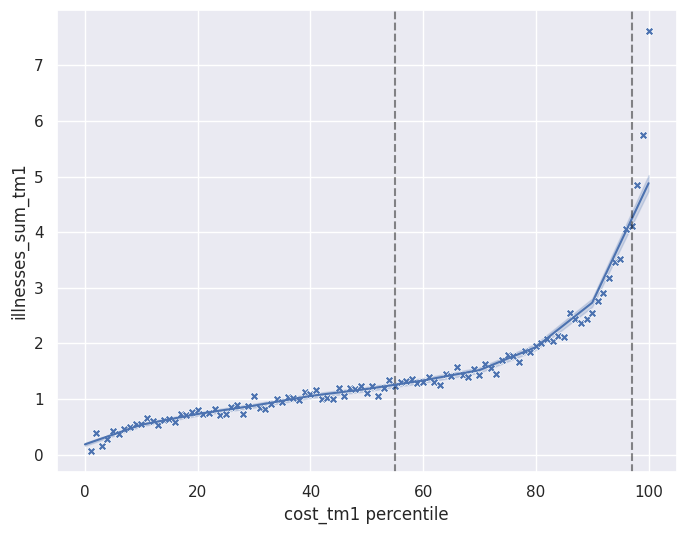

In [63]:
# call the function (T5-Q1) here

plot_x_vs_y(data,
            x_column='cost_tm1',
            y_column='illnesses_sum_tm1')

In [64]:
# Your code here...
answer2 = "The plotted X markers represent the cost_tm1 percentile (x) for the given illnesses_sum_tm1 (y)."
answer3 = "The medical costs variable is a good indicator of the illness conditions for any cost_tm1 above the 80th percentile."

print(f"T5-Q2: {answer2}")
print(f"T5-Q3: {answer3}")

T5-Q2: The plotted X markers represent the cost_tm1 percentile (x) for the given illnesses_sum_tm1 (y).
T5-Q3: The medical costs variable is a good indicator of the illness conditions for any cost_tm1 above the 80th percentile.


### Task 6

We define patients at risk at time t as patients being in the top decile in terms of medical costs at time tm1 (90th+ percentile of `cost_t`).

1. What is the 90th percentile of `cost_tm1`?
2. What is the 90th percentile of `cost_tm1` of black patients?
3. What is the 90th percentile of `cost_tm1` of white patients?

In [70]:
# Your code here...
answer1 = data["cost_tm1"].quantile(q=[0.9]).iloc[0]
answer2 = data.loc[data["black"], "cost_tm1"].quantile(q=[0.9]).iloc[0]
answer3 = data.loc[~data["black"], "cost_tm1"].quantile(q=[0.9]).iloc[0]

print(f"T6-Q1: {answer1}")
print(f"T6-Q2: {answer2}")
print(f"T6-Q3: {answer3}")

T6-Q1: 16387.000000000044
T6-Q2: 22349.000000000007
T6-Q3: 15609.000000000015


## That's all!

If you found a mistake / problem in this notebook, or something was unclear, please post at the `#ds` channel.

**Prepare to explain to your team about this data and the model you've trained.**

### Submission

1. Save the notebook as a pdf file (In Colab: File > Print)
2. Upload in Gradescope http://go.responsibly.ai/gradescope